In [1]:
from gpad_data_generation import *

odf, pedf, ppedf, coefs = music_processor('100605.mp3')

In [2]:
print(pedf[1])

[0.36822566 0.20685749 0.33419704 0.29941607 0.30600044 0.3260313
 0.36221617 0.3180071  0.35274825 0.3936498  0.28667712 0.56435424
 0.26343498 0.5777899  0.4090991  0.4470215  0.4918968  0.65563154
 0.30833125 1.         0.30833125 0.65563154 0.4918968  0.4470215
 0.4090991  0.5777899  0.26343498 0.56435424 0.28667712 0.3936498
 0.35274825 0.3180071  0.36221617 0.3260313  0.30600044 0.29941607
 0.33419704 0.20685749]


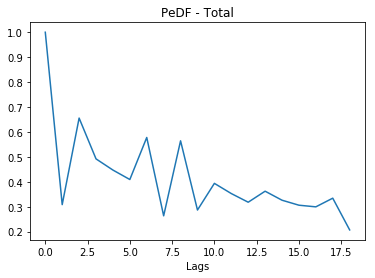

In [3]:
plot_PeDF(ppedf[1], 'partial')

In [4]:
from AE_functions import *


[0 0 0 0 8 9 7]
[0 8 9 7]
[3 0 0 0 8 9 7]


In [5]:
x = v_sc(pedf[1], 5)

(38,)
()
()


In [11]:
print(v_sd(pedf[1]))

TypeError: v_sd() missing 2 required positional arguments: 'f_s_eq' and 'NFFT'